# Proyecto 04 - Sistemas de Recomendación (Mejorado)

https://github.com/nicocarballo93/DS_Proyecto_04_SR

En este proyecto se busca mejorar la performance del modelo presentado en el proyecto numero 3 (RMSE = 3,81). Para lograrlo se procede a aumentar la cantidad de datos adquiridos del dataset original en un 42,73% y optimizar mediante los distintos parametros un modelo de SVD. 

In [1]:
import gzip
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
contador = 0
data_reviews = []
n = 7
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [4]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [5]:
data_reviews = pd.DataFrame(data_reviews)

#### Se procede a realizar el mismo tratamiento en los datos que en el proyecto 3 para que esto no interfiera con la performance del nuevo modelo

In [6]:
data_reviews.product_id = data_reviews.product_id.replace(['NA'],np.nan)
data_reviews = data_reviews[~data_reviews.product_id.isna()]
data_reviews = data_reviews[~data_reviews.user_id.isna()]
data_reviews.shape

(452948, 12)

In [7]:
valor_medio = data_reviews['hours'].mean()
std = data_reviews['hours'].std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data_reviews['hours'] < minimo, data_reviews['hours'] > maximo)
print(valor_medio, std, minimo, maximo)

121.26549068383463 390.4632805374327 -1050.1243509284636 1292.6553322961327


In [8]:
mascara_outliers.value_counts()

False    445375
True       7573
Name: hours, dtype: int64

In [9]:
data_reviews = data_reviews[~mascara_outliers]
data_reviews['hours'].describe()

count    444276.000000
mean         82.877335
std         174.037405
min           0.000000
25%           4.600000
50%          17.900000
75%          68.100000
max        1292.500000
Name: hours, dtype: float64

In [10]:
data_games = data_games.rename(columns={'id':'product_id'})
data_reviews = data_reviews.merge(data_games, on='product_id', how='left')

data_reviews.metascore = data_reviews.metascore.replace(['NA'],np.nan)
data_reviews.metascore = data_reviews.metascore.astype(np.float32)
data_reviews.product_id = data_reviews.product_id.astype(int) 

data_reviews.metascore.value_counts()

84.0    16161
81.0    15887
88.0    14682
83.0    14276
92.0    13800
        ...  
36.0        7
34.0        4
35.0        3
27.0        2
42.0        1
Name: metascore, Length: 69, dtype: int64

In [11]:
print(data_reviews.shape)
data_reviews = data_reviews[~data_reviews.metascore.isna()]
print(data_reviews.shape)

(445764, 27)
(262087, 27)


In [12]:
data_reviews = data_reviews.drop(columns=['products','page_order','date','text','early_access_x','page','found_funny','compensation','publisher','app_name','url','release_date','tags','discount_price','reviews_url','specs','early_access_y','developer','sentiment'])
data_reviews.head(2)

,username,hours,product_id,user_id,genres,title,price,metascore
0,Weaky1100,1.3,350280,76561198048988003,[Action],LawBreakers,29.99,76.0
3,Avpuli,2.1,363520,76561198032237009,"[Action, Adventure, Indie, RPG]",Goliath,11.99,57.0


In [13]:
data_games = data_games[~data_games.product_id.isna()]
data_games.product_id = data_games.product_id.astype(int)

In [14]:
reader = Reader(rating_scale=(1, 100))

df1 = data_reviews.copy()
df1 = df1.drop(['metascore','genres','title','title','price'], axis=1)
df1.head(2)

,username,hours,product_id,user_id
0,Weaky1100,1.3,350280,76561198048988003
3,Avpuli,2.1,363520,76561198032237009


In [15]:
data_games_train = data_games.copy()
df1= pd.merge(df1, data_games_train, on='product_id', how='inner')
df1['user_id'] = df1['user_id'].dropna()
df1 = df1[~df1['user_id'].isnull()]
df1 = df1[df1['metascore']!='NA']
df1.head(2)

,username,hours,product_id,user_id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,Weaky1100,1.3,350280,76561198048988003,Nexon America Inc.,[Action],LawBreakers,LawBreakers,http://store.steampowered.com/app/350280/LawBr...,2017-08-07,"[Action, FPS, Multiplayer, Shooter, Arena Shoo...",NaN,http://steamcommunity.com/app/350280/reviews/?...,"[Multi-player, Online Multi-Player, Steam Achi...",29.99,False,Boss Key Productions,Mostly Positive,76
1,youarenxt1,12.3,350280,76561198392242475,Nexon America Inc.,[Action],LawBreakers,LawBreakers,http://store.steampowered.com/app/350280/LawBr...,2017-08-07,"[Action, FPS, Multiplayer, Shooter, Arena Shoo...",NaN,http://steamcommunity.com/app/350280/reviews/?...,"[Multi-player, Online Multi-Player, Steam Achi...",29.99,False,Boss Key Productions,Mostly Positive,76


### Optimización de parámetros - Modelo (SVD)

In [18]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.7908  1.8761  1.8165  1.8278  0.0357  
Fit time          4.20    3.57    3.50    3.76    0.31    
Test time         0.90    0.86    0.80    0.85    0.04    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8459  1.8654  1.9308  1.8807  0.0363  
Fit time          3.47    3.30    3.03    3.27    0.18    
Test time         0.72    0.85    0.91    0.83    0.08    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.9507  1.9700  1.9654  1.9620  0.0082  
Fit time          3.56    3.38    3.58    3.51    0.09    
Test time         0.50    0.82    0.69    0.67    0.13    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.0396  2.0

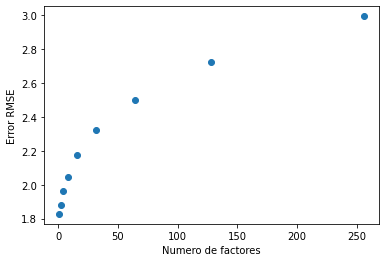

In [19]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [20]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [21]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.9602617543775782
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.002}


In [22]:
rmse_test_means = []
factores = [1,2,4,5,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor, n_epochs=20, lr_all=0.005, reg_all=0.002)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8033  1.7437  1.8170  1.7880  0.0318  
Fit time          3.20    3.27    3.26    3.25    0.03    
Test time         0.61    0.85    0.59    0.68    0.11    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8724  1.8323  1.8847  1.8631  0.0223  
Fit time          3.16    3.28    3.63    3.36    0.20    
Test time         0.88    0.75    0.60    0.74    0.12    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8705  1.9683  1.9529  1.9305  0.0429  
Fit time          3.44    3.45    3.81    3.57    0.17    
Test time         0.85    0.71    0.90    0.82    0.08    
5
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.9859  1.9

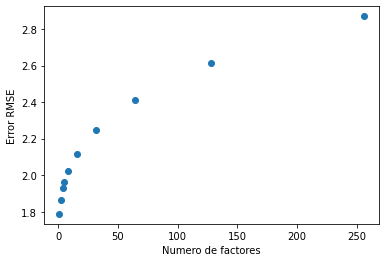

In [23]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

### Entrenamos el modelo teniendo en cuenta los parametros 

In [24]:
reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(df1[['user_id', 'product_id', 'metascore']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)

### Calculamos la performance de nuestro nuevo modelo

In [25]:
rmse_svd_2 = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 1.8543
RMSE: 1.8543


1.8542778998135163

Podemos ver que mejoramos ampliamente el RMSE del modelo planteado en el proyecto 3, pasando de un 3,81 a un 1,85 haciendo uso de un modelo SVD con optimizacion de parametros y ampliando la cantidad de datos para el analisis en un 42,73%. 